In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from stljax.formula import *
from stljax.viz import *


## NOTE
`stljax` expects input signals to be of size `[batch_size, time_dim, state_dim]`.
We are working on generalizing this, but right now, it assumes that particular structure.

Additionally, signals are expected to be *time reversed* when passing through an STL formula. Below are some examples showing how yo do this via Expressions. 

In [2]:
@jax.jit
def dynamics_discrete_step(state, control, dt=0.1):
    '''Single integrator 2d dynamics'''
    return state + control * dt

@jax.jit
def simulate_dynamics(controls, state0, dt):
    T = controls.shape[1]
    _states = [state0]
    for t in range(T):
        _states.append(dynamics_discrete_step(_states[-1], controls[:,t,:], dt))
    return jnp.concatenate(_states, 1)

### basic usage

In [3]:
# define expression (with None value)
# NOTE: Expressions are used for setting up predicates. 
#       The values associated with an expression is more for convenience. 
#       You can use a jnp.array directly when evaluating a formula, rather than using an expressiion with values populated.
distance_to_origin = Expression("magnitude", None, False)
formula = Eventually(distance_to_origin < 0.5)


# this will throw error since the expression value is None.
# (commented out for convenience in running the notebook)
# formula(distance_to_origin)

Robustness trace:  [-2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.5186005
 -2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.477519  -2.4112952
 -2.3951554 -2.256407  -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.2557175 -2.2557175]
Robustness value:  -2.2557175


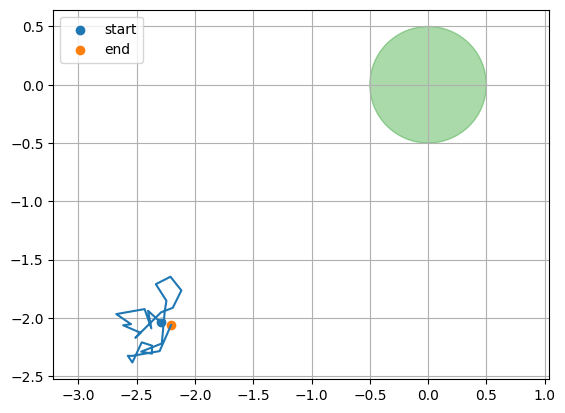

In [4]:
# populate expression with some values. In this example, using a control sequence to generate a state trajectory
T = 25  # time horizon
dt = 0.1
time_dim = 1 # axis corresponding to time dimension
np.random.seed(123)
controls = jnp.array(np.random.randn(1,T,2))   # generate control sequence
state0 = jnp.array(np.random.randn(1,1,2)) - 1.0   # initial state
states = simulate_dynamics(controls, state0, dt)   # simulate state trajectory
states_norm = jnp.linalg.norm(states, axis=-1, keepdims=True)   # compute distance to origin, size [1, 26, 1]
distance_to_origin.set_value(states_norm)   # set value for expression

if not distance_to_origin.reverse:
    distance_to_origin.flip(time_dim)   # reverse the time signal. Expressions help keep track of it for you.

# plotting the trajectory (should look noisy/random)
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.plot(*states[0].T)
ax.scatter(states[0,0,:1], states[0,0,1:], label="start")
ax.scatter(states[0,-1,:1], states[0,-1,1:], label="end")
circle1 = plt.Circle((0, 0), 0.5, color='C2', alpha=0.4)
ax.add_patch(circle1)

plt.xlim([-5,1])
plt.ylim([-4,1])
plt.legend()
plt.grid()
plt.axis("equal")


# will not throw an error now since Expression has a value
# robustness trace
print("Robustness trace: ", formula(distance_to_origin).squeeze())

# robustness value
print("Robustness value: ", formula.robustness(distance_to_origin, time_dim=time_dim).squeeze())


In [5]:
# alternatively, we can just evaluate the robustness (trace) for any jnp.array, not necessarily an expression.
# NOTE: You still need to create an Expression to define a predicate
key = jax.random.PRNGKey(123)  # Random seed is explicit in JAX

# NOTE: Since we are not using Expressions to handle the signals, the user must manually keep track of whether or not the signal is time_reversed or not.
# make a random signal
signal = jax.random.uniform(key, shape=(1, T, 1))  # assuming it's already reversed.
formula(signal)

# and we can take gradients with respect to the signal
def robustness_mean(signal, time_dim, **kwargs):
    # needs to output a scalar 
    return formula.robustness(signal, time_dim, **kwargs).mean()

# taking gradient using the true min/max function
jax.grad(robustness_mean)(signal, time_dim, approx_method="true") # all zeros expect its -1 at the index where the point (0.5 - signal[index]) is the largest

# taking gradient using amin/max approximation method (specify method and temperature), and the gradients should be "spread" to other indices as well
# logsumexp approximation
jax.grad(robustness_mean)(signal, time_dim, approx_method="logsumexp", temperature=10)

# softmax approximation
jax.grad(robustness_mean)(signal, time_dim, approx_method="softmax", temperature=10)

# gmsr approximation (https://arxiv.org/abs/2405.10996)
jax.grad(robustness_mean)(signal, time_dim, approx_method="gmsr", temperature=(1E-6, 1.))

Array([[[-0.0000000e+00],
        [-5.8486069e-08],
        [-0.0000000e+00],
        [-2.1526665e-07],
        [-6.5125056e-07],
        [-2.1939275e-06],
        [-2.6342982e-06],
        [-6.9414928e-06],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-4.6984931e-07],
        [-6.6347835e-05],
        [-1.1823326e-04],
        [-5.1799242e-04],
        [-6.0983184e-05],
        [-6.7584403e-04],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-4.7946586e-03],
        [-1.0270013e-02],
        [-2.5462670e-02],
        [-7.0704646e-02],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-6.6623485e-01]]], dtype=float32)

### gradient descent on control inputs

Now, we can perform gradient descent on the control inputs to make progress towards the formula being true.

In [6]:
# set random initial state and control
np.random.seed(123)
T = 51  # time horizon
dt = 0.1 # time step size
ts = jnp.array([t * dt for t in range(T)])
time_dim = 1
umax = 1.0  # max control limit

controls = jnp.array(np.random.randn(1,T,2))
state0 = jnp.ones(2).reshape([1,1,2]) * 3.
obstacle_center = jnp.ones([1,1,2]) * 2.


In [7]:
# defining formula
distance_to_origin = Expression("magnitude", None, False)
distance_to_obstacle = Expression("distance_to_obs", None, False)
reach = Eventually(distance_to_origin < 0.5)
avoid = Always(distance_to_obstacle > 0.5)
formula = reach & avoid

In [8]:
def loss(controls, state0, umax, dt, coeffs=[1., 0.1, 5.], approx_method="true", temperature=None):
    # generate trajectory from control sequence and reverse along time dimension
    traj_reversed = jnp.flip(simulate_dynamics(controls, state0, dt), axis=1)
    # compute distance_to_origin and distance_to_obstacle
    distance_to_origin_signal = jnp.linalg.norm(traj_reversed, axis=-1, keepdims=True)
    distance_to_obstacle_signal = jnp.linalg.norm(traj_reversed - obstacle_center, axis=-1, keepdims=True)
    # loss functions
    input_signal = (distance_to_origin_signal, distance_to_obstacle_signal)
    loss_robustness = jax.nn.relu(-formula.robustness(input_signal, time_dim=1, approx_method=approx_method, temperature=temperature)).mean()
    loss_control_smoothness = (jnp.diff(controls, axis=1)**2).sum(-1).mean()  # make controls smoother
    loss_control_limits = jax.nn.relu(jnp.linalg.norm(controls, axis=-1) - umax).mean()   # penalize control limit violation
    return coeffs[0] * loss_robustness + coeffs[1] * loss_control_smoothness + coeffs[2] * loss_control_limits

@jax.jit
def true_robustness(controls, state0, dt):
    # generate trajectory from control sequence and reverse along time dimension
    traj_reversed = jnp.flip(simulate_dynamics(controls, state0, dt), axis=1)
    # compute distance_to_origin and distance_to_obstacle
    distance_to_origin_signal = jnp.linalg.norm(traj_reversed, axis=-1, keepdims=True)
    distance_to_obstacle_signal = jnp.linalg.norm(traj_reversed - obstacle_center, axis=-1, keepdims=True)
    # loss functions
    input_signal = (distance_to_origin_signal, distance_to_obstacle_signal)
    return formula.robustness(input_signal, time_dim=1).mean()

def temperature_schedule(i, i_max, start_temp, end_temp, scale=5):
    i_ = i 
    center = i_max / 2
    return jax.nn.sigmoid((i_ - center) / scale) * (end_temp - start_temp) + start_temp

# compare true value with max/min approximation
loss(controls, state0, umax, dt), loss(controls, state0, umax, dt, approx_method="softmax", temperature=5)

(Array(6.64312, dtype=float32), Array(7.0071645, dtype=float32))

In [9]:
states_ = [simulate_dynamics(controls, state0, dt)]
lr = 0.5 # learning rate
approx_method = "logsumexp"
n_steps = 1000   # number of gradient steps
n_steps_extra = 10
coeffs = [1., 0.1, 5.]

# jit the gradient function to speed things up (by A LOT).
grad_jit = jax.jit(lambda controls, temperature: jax.grad(loss, 0)(controls, state0, umax, dt, coeffs, approx_method, temperature))
start_temp = 50
end_temp = 500
scale = 5

for i in range(n_steps):
    temperature = temperature_schedule(i, n_steps, start_temp, end_temp, scale)
    g = grad_jit(controls, temperature)   # take gradient
    # g =  jax.grad(loss, 0)(controls, state0, umax, approx_method, temperature)  # not jitting
    controls -= g * jnp.ones_like(g) * lr
    states_.append(simulate_dynamics(controls, state0, dt))
    if (i % 10) == 0:
        print("%3i -- true robustness: %.2f   smoothness: %.2f    control limits: %.2f"%(i, true_robustness(controls, state0, dt), loss(controls, state0, umax, dt, coeffs=[0., 1., 0.]), loss(controls, state0, umax, dt, coeffs=[0., 0., 1.])))

  0 -- true robustness: -3.23   smoothness: 4.81    control limits: 0.52
 10 -- true robustness: -2.42   smoothness: 2.55    control limits: 0.23
 20 -- true robustness: -1.82   smoothness: 1.53    control limits: 0.11
 30 -- true robustness: -1.41   smoothness: 1.12    control limits: 0.10
 40 -- true robustness: -1.15   smoothness: 0.92    control limits: 0.09
 50 -- true robustness: -1.02   smoothness: 0.79    control limits: 0.09
 60 -- true robustness: -0.96   smoothness: 0.70    control limits: 0.10
 70 -- true robustness: -0.94   smoothness: 0.63    control limits: 0.10
 80 -- true robustness: -0.92   smoothness: 0.57    control limits: 0.10
 90 -- true robustness: -0.90   smoothness: 0.51    control limits: 0.11
100 -- true robustness: -0.45   smoothness: 0.46    control limits: 0.09
110 -- true robustness: -0.20   smoothness: 0.35    control limits: 0.05
120 -- true robustness: 0.00   smoothness: 0.25    control limits: 0.02
130 -- true robustness: -0.01   smoothness: 0.21    

Text(0, 0.5, 'Controls')

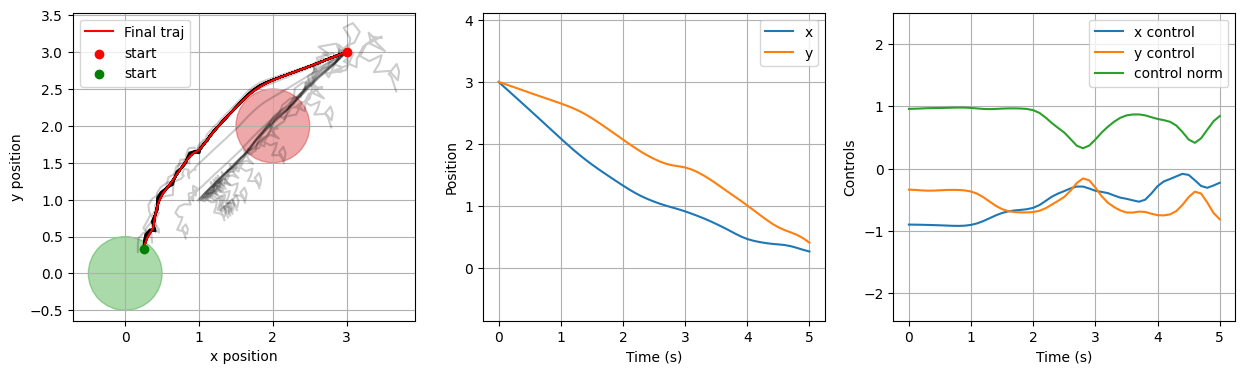

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15,4)) # note we must use plt.subplots, not plt.subplot

ax = axs[0]
circle1 = plt.Circle((0, 0), 0.5, color='C2', alpha=0.4)
circle2 = plt.Circle(obstacle_center[0,0], 0.5, color='C3', alpha=0.4)

ax.add_patch(circle1)
ax.add_patch(circle2)

[ax.plot(*s[0].T, color="k", alpha=0.2) for s in states_[::10]]
[ax.plot(*s[0].T, color="r", label="Final traj") for s in states_[-1:]]

ax.scatter(states_[-1][0,0,:1], states_[-1][0,0,1:], zorder=10, label="start", color="red")
ax.scatter(states_[-1][0,-1,:1], states_[-1][0,-1,1:], zorder=10, label="start", color="green")

ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.grid()
ax.legend()
ax.axis("equal")

# plot x, y
ax = axs[1]
ax.plot(ts, states_[-1][0,:-1,:1], label="x")
ax.plot(ts, states_[-1][0,:-1,1:], label="y")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position")


# plot control signal
ax = axs[2]
ax.plot(ts, controls[0,:,:1], label="x control")
ax.plot(ts, controls[0,:,1:], label="y control")
ax.plot(ts, jnp.linalg.norm(controls, axis=-1).squeeze(), label="control norm")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Controls")


In [11]:
%timeit grad_jit(controls, temperature)
# %timeit jax.grad(loss, 0)(controls, state0, umax, approx_method, temperature) 

70.2 μs ± 1.28 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Examples of other formulas

Below are examples of how to apply different STL operations given the reach and avoid predicates.
(Don't read too much into the meaning behind each formula with the read and avoid predicates. Just treat them as placeholders)


In [12]:
# using values from above
traj = states_[-1]
# traj_reversed = jnp.flip(simulate_dynamics(controls, state0, dt), axis=1)
# compute distance_to_origin and distance_to_obstacle
distance_to_origin_signal = jnp.linalg.norm(traj, axis=-1, keepdims=True)
distance_to_obstacle_signal = jnp.linalg.norm(traj - obstacle_center, axis=-1, keepdims=True)


distance_to_origin = Expression("magnitude", distance_to_origin_signal, False)
distance_to_obstacle = Expression("distance_to_obs", distance_to_obstacle_signal, False)
reach = Eventually(distance_to_origin < 0.5)
avoid = Always(distance_to_obstacle > 0.5)


### Eventually Always

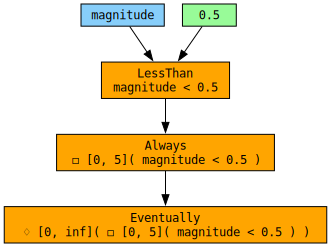

In [13]:
# nested temporal operators
# NOTE: temporal operatos pad signal with the value at the last time step
ϕ = Eventually(Always(distance_to_origin < 0.5, interval=[0, 5]))

if not distance_to_origin.reverse:
    distance_to_origin.flip(time_dim)   # reverse the time signal. Expressions help keep track of it for you.

ϕ(distance_to_origin);
make_stl_graph(ϕ)


### Until

In [14]:
ϕ = Until(avoid, reach)

if not distance_to_origin.reverse:
    distance_to_origin.flip(time_dim)   

if not distance_to_obstacle.reverse:
    distance_to_obstacle.flip(time_dim)  

ϕ((distance_to_obstacle, distance_to_origin));

### Multiple And (Or)

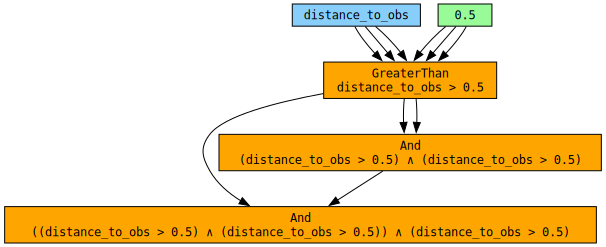

In [15]:
ψ = distance_to_obstacle > 0.5
ϕ = ψ & ψ & ψ  # equivalent to (ψ & ψ) & ψ  this formula is redundant, but just demonstrating functionality
ϕ(((distance_to_obstacle,distance_to_obstacle), distance_to_obstacle));
make_stl_graph(ϕ)

# similarly, you can do this with Or --> ψ | ψ | ψ


### Implies

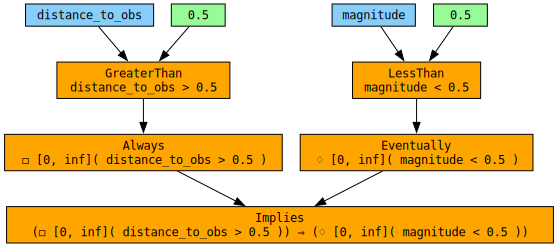

In [16]:
ϕ = Implies(avoid, reach)
ϕ((distance_to_obstacle,distance_to_obstacle));
make_stl_graph(ϕ)
